Ontario Parks released dataset on visitation counts for all operating provincial parks here: https://data.ontario.ca/en/dataset/visitation-to-provincial-parks

Let's explore this dataset and see what we can learn from it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('OntarioParks.xlsx')
df.head()

,Zone,Park,Year,Day Visitation,Camper Nights,Total Visitation,July August Car Camping Occupancy
0,Northwest,aaron,2020,2672.8,19459.0,22131.8,0.46
1,Algonquin,algonquin,2020,224904.0,809473.4,1034377.4,0.93
2,Algonquin,arrowhead,2020,120360.0,139690.4,260050.4,0.95
3,Northwest,arrowlake,2020,0.0,10035.0,10035.0,0.81
4,Southwest,awenda,2020,55026.0,97179.4,152205.4,0.95


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,114.0,2020.000000,0.000000,2020.0,2020.0000,2020.00,2020.00,2020.00
Day Visitation,114.0,48106.298246,144406.168849,0.0,1736.0000,12250.75,33226.45,1373948.30
Camper Nights,111.0,51042.247748,91161.473905,0.0,8970.8000,27909.10,63841.60,809473.40
Total Visitation,114.0,97805.328947,184752.100420,0.0,17731.0000,49235.40,91861.85,1373948.30
July August Car Camping Occupancy,86.0,0.767558,0.226643,0.0,0.7025,0.84,0.92,0.99


A quick look at the data, we discover that 'Year' column is always 2020, so we can safely drop this column. There are two main metrics for visitation: 'Day Visitation' and 'Camper Nights', according to the data notes, 'Day Visitation' is an estimate of all the dayuse users, and 'Camper Nights' counts total people staying in campsites overnight. 'Total Visitation' is simply the sum of the two, and 'July August Car Camping Occupancy' describes percentage of campsites occupied out of all available campsites.

In [21]:
# df = df.drop('Year', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zone                               114 non-null    object 
 1   Park                               114 non-null    object 
 2   Day Visitation                     114 non-null    float64
 3   Camper Nights                      111 non-null    float64
 4   Total Visitation                   114 non-null    float64
 5   July August Car Camping Occupancy  86 non-null     float64
dtypes: float64(4), object(2)
memory usage: 5.5+ KB


Both day visitation and camper nights are such big numbers, let's visualize them with a scatterplot:

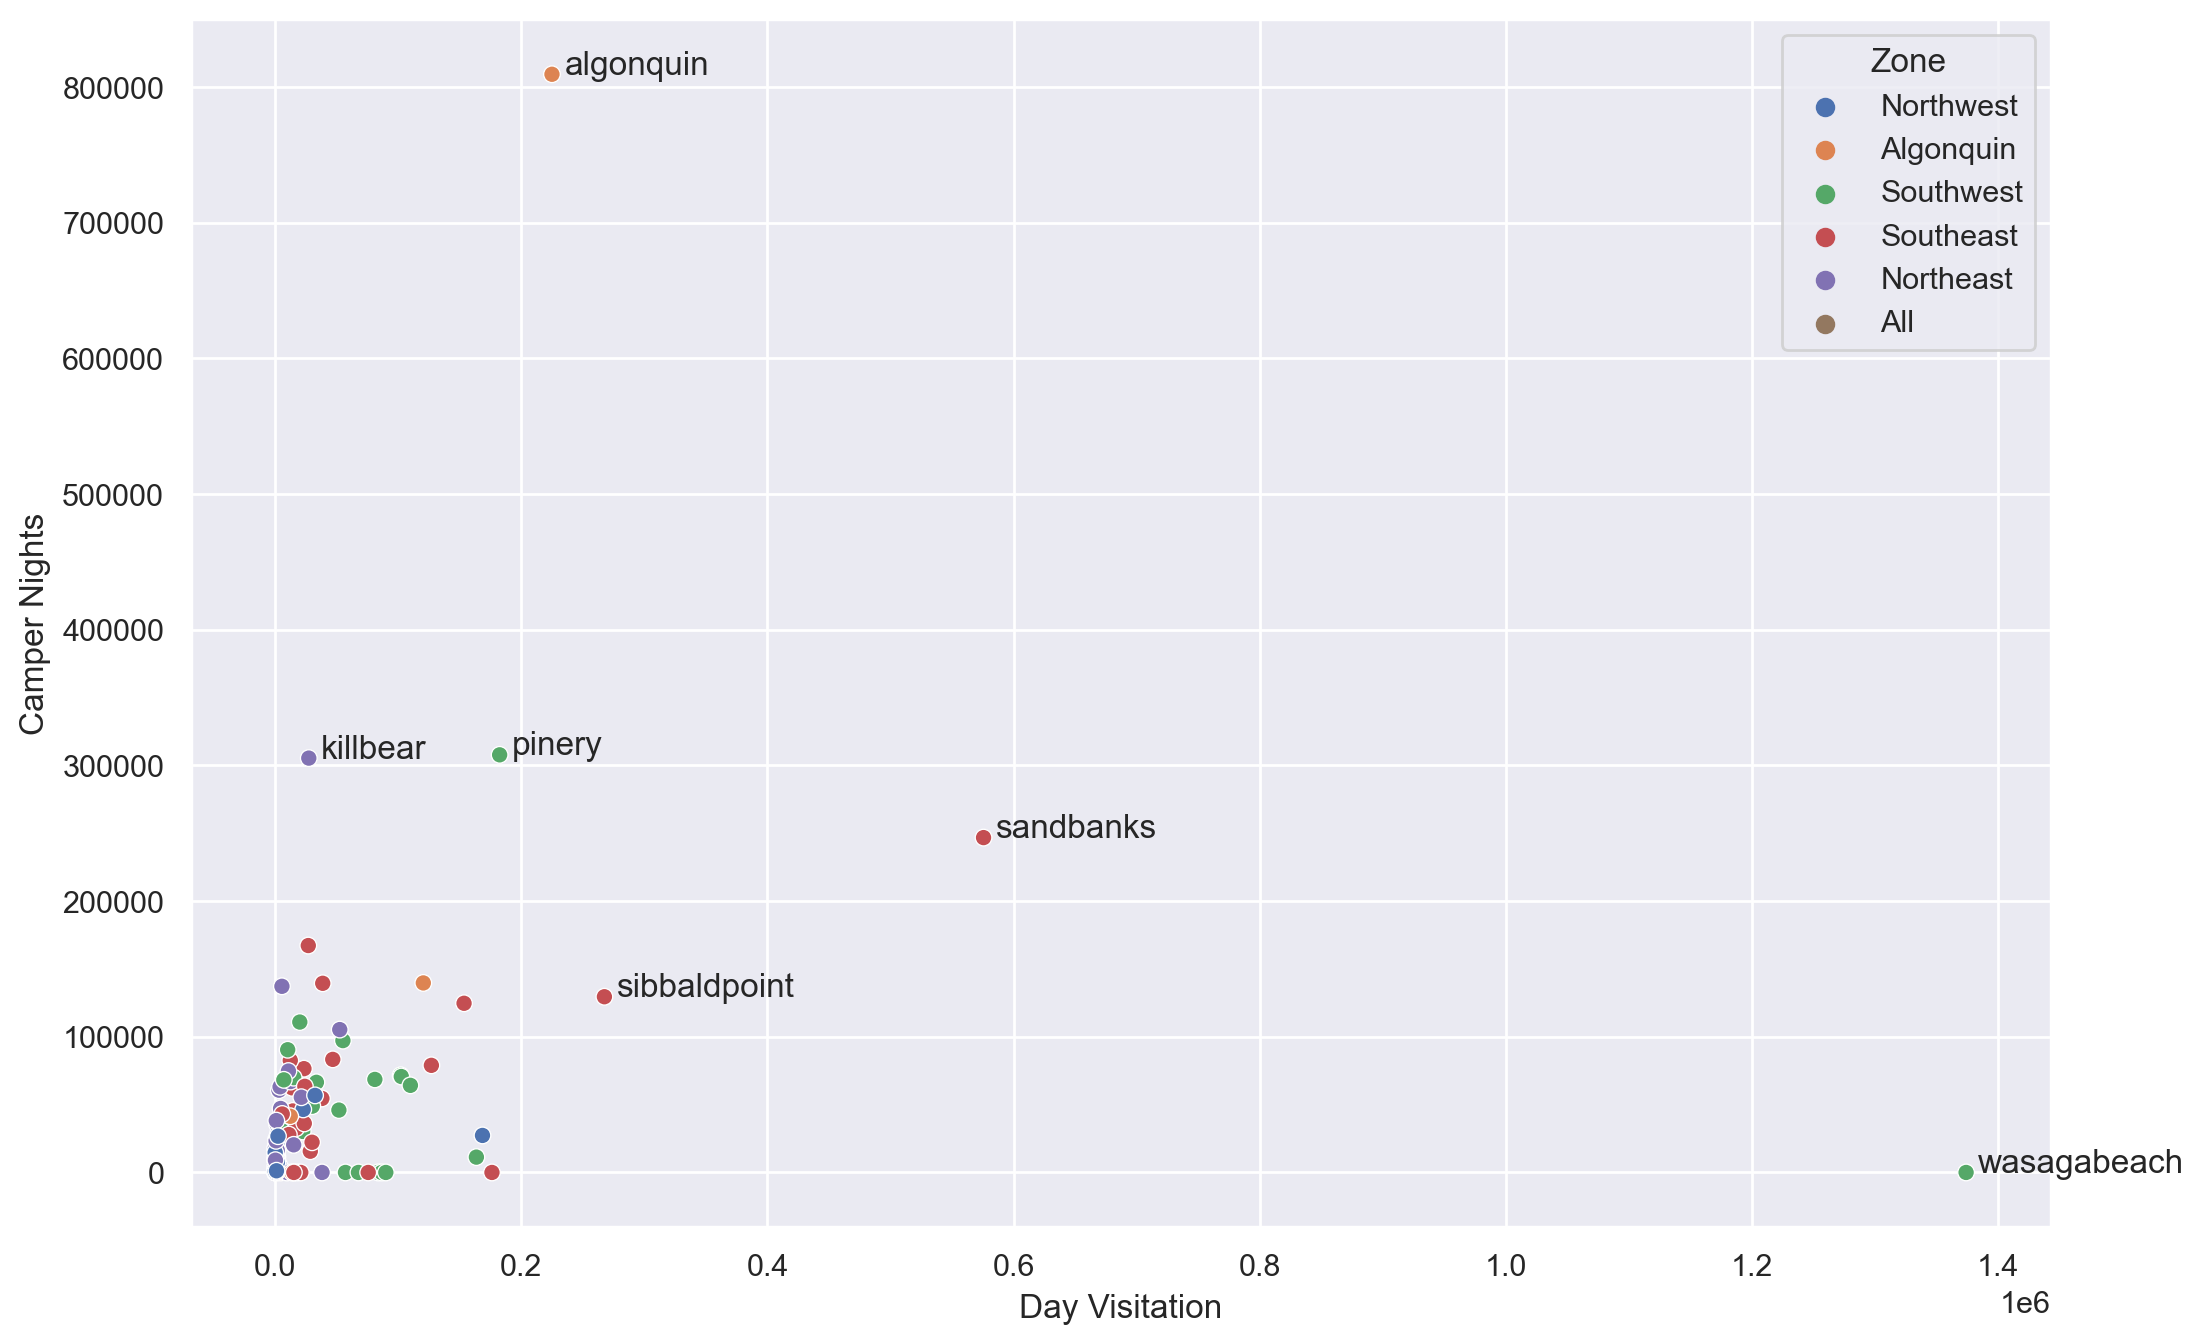

In [42]:
plt.figure(figsize=(12,8), dpi=200)
sns.set_theme()
p1 = sns.scatterplot(data=df, x='Day Visitation', y='Camper Nights', hue='Zone')
# find the top 5 parks with most total visitors and then annotate them on thep plot. 
top_parks = [x for x in df.sort_values('Total Visitation', ascending=False)['Park'].head(6)]
for park in top_parks:
    plt.text(x=df['Day Visitation'][df['Park']==park]+10000, 
             y=df['Camper Nights'][df['Park']==park], s=park)